##### ** Описание **

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib

# from imp import reload
# from html.parser import HTMLParser

from collections import namedtuple

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import numpy

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
def to_unicode(text):
    if not isinstance(text, unicode): text = text.decode('utf8')
    return text

def to_utf8(text):
    if isinstance(text, unicode): text = text.encode('utf8')
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, unicode): text = text.decode('utf8')
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from HTMLParser import HTMLParser
import re

### Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = unicode()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = unicode()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print 'threshold %s' % threshold
            print '\tclass_prec %s, class_recall %s, class_F1 %s' % r[0]
            print '\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1]
            print '\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2)
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
class MyHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.html = 0
        self.head = 0
        self.title = 0
        self.body = 0
        self.anchor = 0
        self.title_data = ''
        self.anchor_data = ''
        self.all_data = ''
        
    def handle_starttag(self, tag, attrs):
        if tag == 'html':
            self.html += 1
        if tag == 'head':
            self.head += 1
        if tag == 'title':
            self.title += 1
        if tag == 'body':
            self.body += 1
        if tag == 'a':
            self.anchor += 1

    def handle_endtag(self, tag):
        if tag == 'html':
            self.html -= 1
        if tag == 'head':
            self.head -= 1
        if tag == 'title':
            self.title -= 1
        if tag == 'body':
            self.body -= 1
        if tag == 'a':
            self.anchor -= 1

    def handle_data(self, data):
        if self.html == 1 and self.head == 1 and self.title == 1:
            self.title_data += data + ' '
        if self.html == 1 and self.body == 1 and self.anchor == 1:
            self.anchor_data += data + ' '
        self.all_data += data + ' '
            
    def get_title_words(self):
        return filter(None, map(str.rstrip, re.split(' ', to_utf8(self.title_data))))

    def get_anchor_words(self):
        return filter(None, map(str.rstrip, re.split(' ', to_utf8(self.anchor_data))))  
    
    def get_all_words(self):
        return filter(lambda word : len(word) < 11, filter(None, map(str.rstrip, re.split(' ', to_utf8(self.all_data)))))
    
    def get_all_text(self):
        self.all_data = re.sub('[(\r\n|\r|\n)]+', ' ', self.all_data)
        self.all_data = re.sub(u'[^0-9a-zA-Zа-яА-Я ]+', '', self.all_data)
        self.all_data = re.sub(' +', ' ', self.all_data)
        return self.all_data

In [11]:
def calc_features(url, html_data):
    parser = MyHTMLParser()
    parser.feed(to_unicode(html_data))
    
    words = list(html2word(html_data))
    title_words = parser.get_title_words()
    anchor_words = parser.get_anchor_words()
    
    words_num = len(words) #0
    avg_word_len = 0 
    for word in words:
        avg_word_len += len(word)
    avg_word_len /= words_num #1
    title_words_num = len(title_words)     #2
    anchor_words_num = len(anchor_words)    #3
    compression_level = float(len(to_utf8(html_data).encode('zlib'))) / len(html_data) #4
    
    return [len(words), avg_word_len, title_words_num, anchor_words_num, compression_level], parser.get_all_text(), parser.get_all_words()

In [12]:
from lxml import html

In [13]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
<title> alskgn jhgqqqqqqq </title>
</html>
'''
test_url = 'http://ololo'
test_features, test_text, test_words = calc_features(test_url, test_html_data)
print (test_words)

['Ololo', '\xd1\x81\xd0\xbf\xd0\xb0\xd0\xbc', '1', '2', '3', 'alskgn', 'jhgqqqqqqq']


In [14]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features', 'text', 'words'])

WORKER_NUM = 8

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features, text, words = calc_features_f(url, html_data)            
            yield DocItem(url_id, mark, url, features, text, words)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features, text, words = calc_features_f(url, html_data)            
            res_queue.put(DocItem(url_id, mark, url, features, text, words))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in xrange(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [15]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))
# test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

14:50:30 INFO:Complete items 00000 in worker_id 0
14:50:30 INFO:Complete items 00000 in worker_id 1
14:50:30 INFO:Complete items 00000 in worker_id 2
14:50:30 INFO:Complete items 00000 in worker_id 3
14:50:30 INFO:Complete items 00000 in worker_id 4
14:50:30 INFO:Complete items 00000 in worker_id 6
14:50:30 INFO:Complete items 00000 in worker_id 5
14:50:30 INFO:Complete items 00000 in worker_id 7
14:50:37 INFO:Complete items 01000 in worker_id 0
14:50:38 INFO:Complete items 01000 in worker_id 6
14:50:39 INFO:Complete items 01000 in worker_id 5
14:50:40 INFO:Complete items 01000 in worker_id 3
14:50:44 INFO:Complete items 01000 in worker_id 2
14:50:45 INFO:Complete items 02000 in worker_id 6
14:50:46 INFO:Complete items 02000 in worker_id 0
14:50:47 INFO:Complete items 02000 in worker_id 3
14:50:49 INFO:Complete items 02000 in worker_id 5
14:50:49 INFO:Complete items 01000 in worker_id 4
14:50:53 INFO:Complete items 01000 in worker_id 7
14:50:54 INFO:Complete items 03000 in worker_id 6


CPU times: user 2.93 s, sys: 670 ms, total: 3.6 s
Wall time: 1min 21s


In [16]:
print len(train_docs)
# print len(test_docs)
train_texts = []
train_labels = []

for doc in train_docs:
    train_texts.append(doc.text)
    train_labels.append(doc.is_spam)

7044


/home/lepossum/.local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


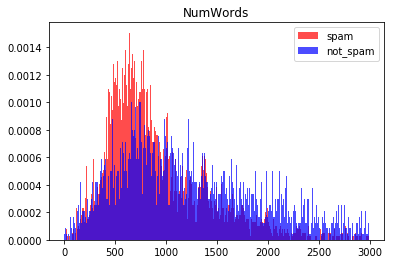

In [17]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

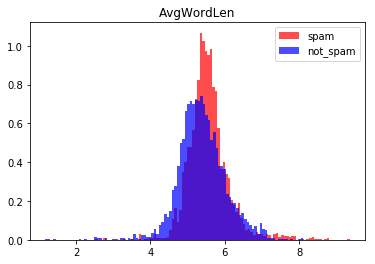

In [18]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
# plt.subplot(1,2,1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
# plt.subplot(1,2,2)
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

In [19]:
print(list([doc.features[2] for doc in train_docs])[0 : 10])

[4, 3, 3, 5, 2, 12, 5, 14, 7, 0]


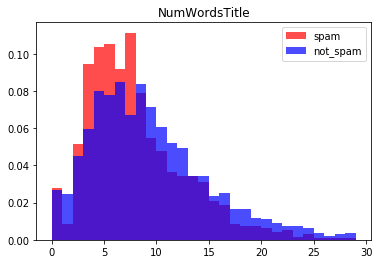

In [20]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(30)
# bins = 30
# plt.subplot(1,2,1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
# plt.subplot(1,2,2)
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

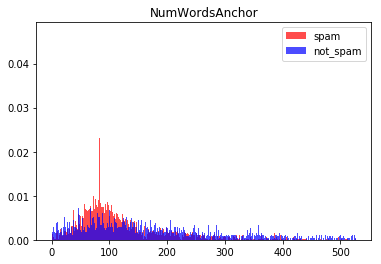

In [21]:
#Добавить графики для остальных фичей
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 528)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsAnchor')
plt.legend()
plt.show()

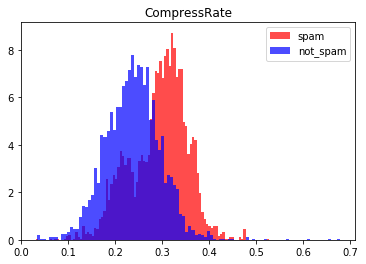

In [22]:
is_spam_data = [doc.features[4] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[4] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('CompressRate')
plt.legend()
plt.show()

** Классификатор: **
Нужно реализовать

In [23]:
class Classifier:
    
    def __init__(self):
        
        self.model = Pipeline([('CV', CountVectorizer(analyzer='char', ngram_range=[1,3])),
#         self.model = Pipeline([('CV', CountVectorizer(analyzer='word', min_df=0.1, max_df=0.8, ngram_range=[1,3])),
                               ('TfIdf', TfidfTransformer()),
                               ('XGB', XGBClassifier(n_estimators=1500, max_deepth=12, n_jobs=12))])

    def predict(self, doc):
        result = self.model.predict([doc.text])
        return result
    
    def predict_proba(self, doc):
        result = self.model.predict_proba([doc.text])
        return result
        
    def predict_all(self, docs):
        result = []
        for doc_num, doc in enumerate(docs):   
            result.append((doc.doc_id, doc.is_spam, doc.url, self.predict_proba(doc)))            
            trace(doc_num)
        return result
    
    def train(self, train_texts, train_labels):
        self.model.fit(train_texts, train_labels)

In [24]:
%%time
classifier = Classifier()
classifier.train(train_texts, train_labels)

CPU times: user 1h 41min 31s, sys: 4.36 s, total: 1h 41min 36s
Wall time: 14min 15s


In [25]:
#Посмотреть, что предсказывается для тестового html
classifier.predict_proba(DocItem(0, 0, test_url , test_features, test_text, test_words))

array([[0.9442586 , 0.05574145]], dtype=float32)

In [26]:
classifier.predict_all([DocItem(0, 0, test_url , test_features, test_text, test_words)])

15:06:11 INFO:Complete items 00000


[(0, 0, 'http://ololo', array([[0.9442586 , 0.05574145]], dtype=float32))]

** Рисуем графики **

plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

In [28]:
%%time

TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv_multiprocess(TEST_DATA_FILE, calc_features)

threshold = 0.5

with open('my_submission_0.5.csv' ,'wb') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for item in classifier.predict_all(test_docs):
        prediction =  1 if item[3][1] > threshold else 0
        writer.writerow([item[0], prediction])

15:23:32 INFO:Complete items 00000 in worker_id 0
15:23:32 INFO:Complete items 00000 in worker_id 1
15:23:32 INFO:Complete items 00000 in worker_id 2
15:23:32 INFO:Complete items 00000 in worker_id 3
15:23:32 INFO:Complete items 00000 in worker_id 4
15:23:32 INFO:Complete items 00000 in worker_id 5
15:23:32 INFO:Complete items 00000 in worker_id 6
15:23:32 INFO:Complete items 00000 in worker_id 7
15:23:32 INFO:Complete items 00000
15:23:45 INFO:Complete items 01000 in worker_id 1
15:23:45 INFO:Complete items 01000 in worker_id 2
15:23:47 INFO:Complete items 01000 in worker_id 5
15:23:48 INFO:Complete items 01000 in worker_id 6
15:23:53 INFO:Complete items 01000 in worker_id 7
15:23:56 INFO:Complete items 02000 in worker_id 2
15:23:57 INFO:Complete items 01000 in worker_id 4
15:24:00 INFO:Complete items 02000 in worker_id 5
15:24:07 INFO:Complete items 02000 in worker_id 1
15:24:15 INFO:Complete items 01000 in worker_id 3
15:24:16 INFO:Complete items 02000 in worker_id 6
15:24:25 INFO:C

IndexError: index 1 is out of bounds for axis 0 with size 1